Dataset loading done!
Columns: ['Date', 'Category', 'Type', 'Amount']

Data preprocessing completed
First five rows of monthly totals:
              Amount
Date                
2000-01-01  12567.41
2000-02-01   8469.91
2000-03-01  10234.60
2000-04-01  10260.59
2000-05-01  10567.83

Training months: 228
Testing months: 58
Model got trained

Model Evaluation:-
Mean Absolute Error (MAE):  721.02
Mean Squared Error (MSE):   1652723.92
Root Mean Squared Error:    1285.58


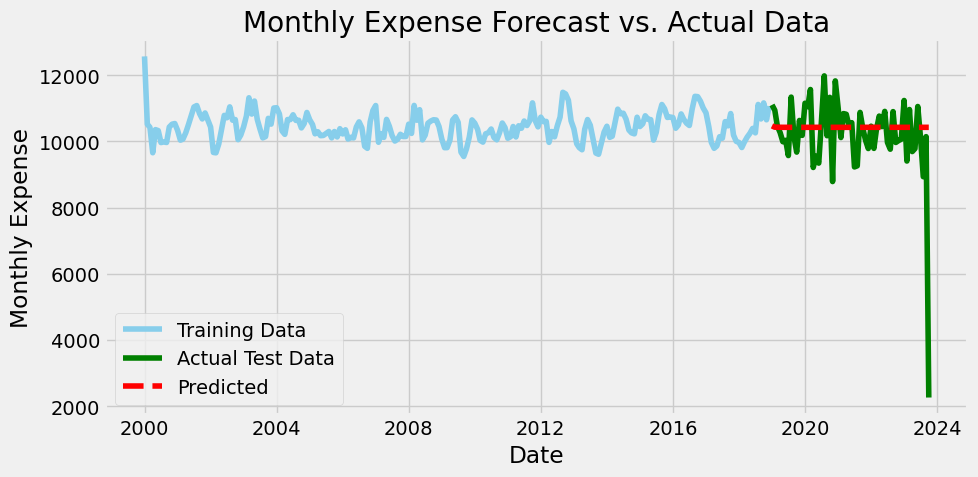

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

file_path = r'C:\Users\Thota Ravindranath\Desktop\MyProject\single_person_expenses_50k.csv'
df = pd.read_csv(file_path)
print("Dataset loading done!")

print("Columns:", df.columns.tolist())

# pre-processing _columns
date_col = 'Date'
amount_col = 'Amount'
type_col = 'Type'

df[date_col] = pd.to_datetime(df[date_col], format='mixed', errors='coerce', dayfirst=True) #formattingDaet
df = df.dropna(subset=[date_col])  # Droping the invalid date rows

# expenses
df_expense = df[df[type_col].str.lower() == 'expense'].copy()

# -ve expense amounts to +ve
df_expense[amount_col] = df_expense[amount_col].abs()

# date - index
df_expense.set_index(date_col, inplace=True)

# add monthly expe & modify nulls
df_monthly = df_expense[[amount_col]].resample('MS').sum().sort_index() # MS = Month Start
df_monthly = df_monthly.replace(0, np.nan).ffill()

print("\nData preprocessing completed")
print("First five rows of monthly totals:")
print(df_monthly.head()) 

# train&test
split_point = int(len(df_monthly) * 0.8)
train_data = df_monthly.iloc[:split_point]
test_data = df_monthly.iloc[split_point:]

print(f"\nTraining months: {len(train_data)}")
print(f"Testing months: {len(test_data)}")

# Arima
model = ARIMA(train_data[amount_col], order=(3, 1, 1))
model_fit = model.fit()
print("Model got trained")

# predict
#print("\nForecasting monthly expenses:")
forecast_res = model_fit.get_forecast(steps=len(test_data))
predictions = forecast_res.predicted_mean

# actual and predicted values
results = pd.concat([
    test_data[amount_col].rename('Actual'),
    predictions.rename('Predicted')
], axis=1).dropna()

# Performance
mae = mean_absolute_error(results['Actual'], results['Predicted'])
mse = mean_squared_error(results['Actual'], results['Predicted'])
rmse = np.sqrt(mse)

print("\nModel Evaluation:-")
print(f"Mean Absolute Error (MAE):  {mae:.2f}")
print(f"Mean Squared Error (MSE):   {mse:.2f}")
print(f"Root Mean Squared Error:    {rmse:.2f}")


# visualization
plt.figure(figsize=(10, 5))
plt.plot(train_data[amount_col].rolling(3, min_periods=1).mean(), label='Training Data', color='skyblue')
plt.plot(test_data[amount_col], label='Actual Test Data', color='green')
plt.plot(results['Predicted'], label='Predicted', color='red', linestyle='--')

plt.title('Monthly Expense Forecast vs. Actual Data')
plt.xlabel('Date')
plt.ylabel('Monthly Expense')
plt.legend()
plt.tight_layout()
plt.show()


Data preprocessing completed
First five rows of monthly totals:
              Amount
Date                
2000-01-01  12567.41
2000-02-01   8469.91
2000-03-01  10234.60
2000-04-01  10260.59
2000-05-01  10567.83

Training months: 228
Testing months: 58
Model got trained

Model Evaluation:-
Mean Absolute Error (MAE):  758.24
Mean Squared Error (MSE):   1837662.57
Root Mean Squared Error:    1,355.60


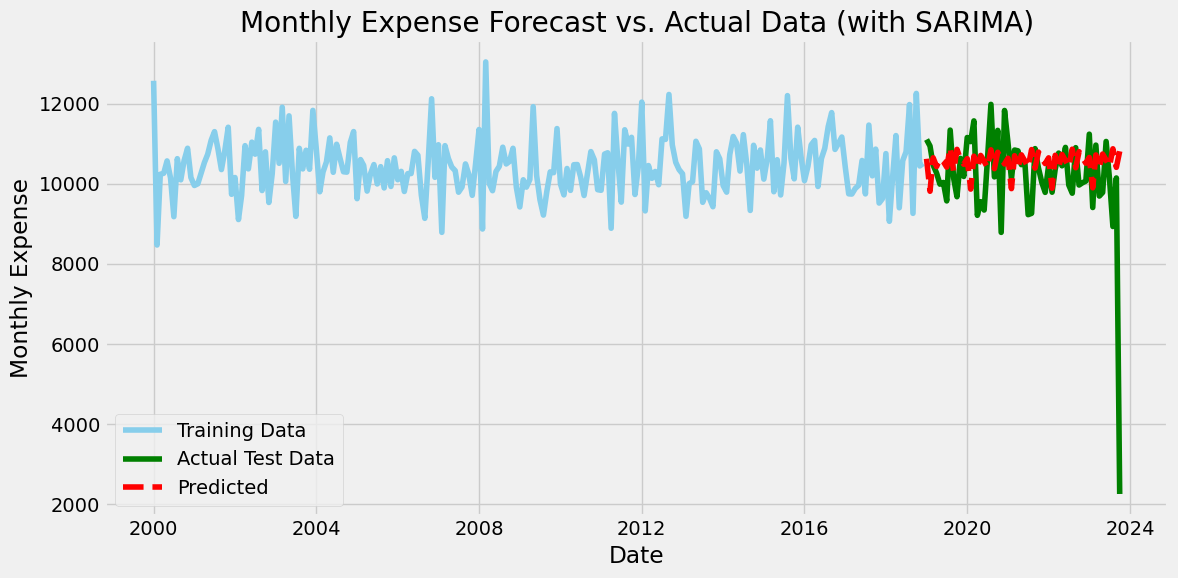

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use('fivethirtyeight')

file_path = r'C:\Users\Thota Ravindranath\Desktop\MyProject\single_person_expenses_50k.csv'
df = pd.read_csv(file_path)

# columns
date_col = 'Date'
amount_col = 'Amount'
type_col = 'Type'

# Preprocessing
df[date_col] = pd.to_datetime(df[date_col], format='mixed', errors='coerce', dayfirst=True)
df = df.dropna(subset=[date_col])
df_expense = df[df[type_col].str.lower() == 'expense'].copy()
df_expense[amount_col] = df_expense[amount_col].abs()
df_expense.set_index(date_col, inplace=True)

# sum of monthly totals
df_monthly = df_expense[[amount_col]].resample('MS').sum().sort_index()
df_monthly = df_monthly.replace(0, np.nan).ffill()

print("\nData preprocessing completed")
print("First five rows of monthly totals:")
print(df_monthly.head())

# train & test
split_point = int(len(df_monthly) * 0.8)
train_data = df_monthly.iloc[:split_point]
test_data = df_monthly.iloc[split_point:]

print(f"\nTraining months: {len(train_data)}")
print(f"Testing months: {len(test_data)}")

#sarima
model = SARIMAX(train_data[amount_col],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))

model_fit = model.fit(disp=False) # disp=False turns off verbose training output
print("Model got trained")

# predictions
predictions = model_fit.get_forecast(steps=len(test_data)).predicted_mean

# actual & predicted values
results = pd.concat([
    test_data[amount_col].rename('Actual'),
    predictions.rename('Predicted')
], axis=1).dropna()

# Performance
mae = mean_absolute_error(results['Actual'], results['Predicted'])
mse = mean_squared_error(results['Actual'], results['Predicted'])
rmse = np.sqrt(mse)

print("\nModel Evaluation:-")
print(f"Mean Absolute Error (MAE):  {mae:,.2f}")
print(f"Mean Squared Error (MSE):   {mse:.2f}")
print(f"Root Mean Squared Error:    {rmse:,.2f}")

# visualize
plt.figure(figsize=(12, 6))
plt.plot(train_data[amount_col], label='Training Data', color='skyblue')
plt.plot(test_data[amount_col], label='Actual Test Data', color='green')
plt.plot(results['Predicted'], label='Predicted', color='red', linestyle='--')

plt.title('Monthly Expense Forecast vs. Actual Data (with SARIMA)')
plt.xlabel('Date')
plt.ylabel('Monthly Expense')
plt.legend()
plt.tight_layout()
plt.savefig('sarima_forecast.png')
plt.show()
